In [1]:
#@title setup colab env
from IPython.display import clear_output
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/commonlitreadabilityprize/baseline/

!pip install transformers
clear_output()

In [2]:
#@title setup XLA
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
clear_output()

In [3]:
import sys
sys.path.append('../input/learner')

from learner.all import *

In [4]:
import os
assert os.environ['COLAB_TPU_ADDR']
 
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [5]:
#@title lib { vertical-output: true }
# lib
import os
import gc
import random
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from typing import Callable, List, Union

from fastprogress import master_bar, progress_bar
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers


import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.9.0+cu102'

In [6]:
data_path = '../input/commonlitreadabilityprize/'

trn_df = pd.read_csv(data_path + 'train.csv')
#trn_df.drop(trn_df.query('target == 0').index, inplace=True)
#trn_df.reset_index(inplace=True)
test_df = pd.read_csv(data_path + 'test.csv')
sub_df = pd.read_csv(data_path + 'sample_submission.csv')

In [7]:
def mse(preds, ys): return ((preds - ys) ** 2).mean()
def rmse(preds, ys): return ((preds - ys) ** 2).mean() ** 0.5
def mae(preds, ys): return abs(preds - ys).mean()

# config

In [8]:
class CFG:
    debug: bool = False
    seed = SEED

    # device
    device = xm.xla_device()
    #device:torch.device = torch.device('cpu')
    #device: torch.device = torch.device('cuda:0')
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data set
    bs: int = 8
    num_workers: int = 0

    # model
    model_name = 'roberta-base'
    store_name = 'roberta-base'
    epochs: int = 5

    # gradient
    iters_to_accumulate: int = 4
    max_grad_norm: float = 1.
    loss_func = None
    metric_funcs: List[Union[Callable, None]] = [rmse, mae]

    # optimizer
    lr: int = 2e-5
    lrs: float = [lr, lr*2, lr*5, lr*10]  # 4 groups
    wd: float = 1e-2
        
    # tokenizer
    max_len = 256


cfg = CFG()
cfg.loss_func = nn.MSELoss()


if cfg.debug:
    trn_df = trn_df.sample(frac=0.30).reset_index()
    warnings.filterwarnings('always')
    pass

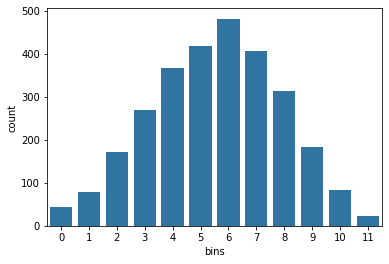

In [9]:
bins = round(1 + np.log2(len(trn_df)))
trn_df['bins'] = pd.cut(trn_df.target, bins, labels=False)

sns.countplot(trn_df['bins'], color='C0')


skf = KFold(5, shuffle=True, random_state=cfg.seed)
for fold, (trn_idx, val_idx) in enumerate(skf.split(trn_df, y=trn_df.bins), 1):
    trn_df.loc[val_idx, 'fold'] = fold
trn_df.loc[trn_df.target == 0, 'fold'] = -1

# dataset

In [10]:
class BERTDataSet(Dataset):
    def __init__(self, df, tokenizer):
        self.encodeds = tokenizer.batch_encode_plus(
            df.excerpt.tolist(),
            add_special_tokens=True,  # <s> and </s>
            max_length=cfg.max_len,          # default 512 for bert
            padding='max_length',    # padding  <pad>
            truncation=True,         # cut if length > max length
           
        )
        self.targets = df.target.values[:, None]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):

        ids = torch.tensor(self.encodeds['input_ids'][idx], dtype=torch.long)
        mask = torch.tensor(self.encodeds['attention_mask'][idx], dtype=torch.long)

        target = torch.tensor(self.targets[idx], dtype=torch.float)

        return [ids, mask], target
    
    
if cfg.debug:
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    print(len(trn_ds))
    for x in trn_dl:
        print(x)
        break

# model

In [11]:
class AttentionHead(nn.Module):
    def __init__(self, in_size=768, h_size=512, o_size=1):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_size, h_size), 
            nn.Tanh(),  
            nn.Linear(h_size, o_size), 
            nn.Softmax(dim=1)
        )
        #self.linear = nn.Linear(in_size, o_size)
        
    def forward(self, features):
        out = self.attention(features) * features
        # (bs, lens, 768) to (bs, 768)
        out = torch.sum(out, dim=1)
        #out = self.linear(out)
        return out
    
    
class CLPRModel(nn.Module):
    def __init__(self, model_name):
        super(CLPRModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.layer_norm_eps = 1e-7
        self.config.hidden_dropout_prob = 0.5
        self.transformer = AutoModel.from_pretrained(model_name, self.config)
        
        self.hidden_size = self.config.hidden_size
        self.attention = AttentionHead(in_size=self.hidden_size)
        self.head = nn.Linear(self.hidden_size, 1)
        
    #def forward(self, input_id, attention_mask):
    def forward(self, x):
        #out = self.transformer(input_id, attention_mask)['last_hidden_state']
        out = self.transformer(*x)['last_hidden_state']
        out = self.attention(out)
        out = self.head(out)
        return out
 
    
if cfg.debug:
    model = CLPRModel(cfg.model_name)
    preds = model(x[0])
    print(preds.shape)

# optimizer

In [12]:
def create_optimizer(model, cfg):
    named_parameters = list(model.named_parameters())

    backbone_parameters = named_parameters[:199]
    head_parameters = named_parameters[199:]

    head_group = [params for (name, params) in head_parameters]

    parameters = []
    parameters.append({"params": head_group,
                       "weight_decay": 0.,
                       "lr": cfg.lrs[3]})

    for layer_num, (name, params) in enumerate(backbone_parameters):
        weight_decay = 0.0 if 'LayerNorm' in name or 'bias' in name else cfg.wd

        lr = cfg.lrs[0]

        if layer_num >= 69:
            lr = cfg.lrs[1]

        if layer_num >= 133:
            lr = cfg.lrs[2]

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters)


def get_scheduler(optimizer, cfg):
    num_training_steps = len(trn_dl) * cfg.epochs
    num_warmup_steps = int(len(trn_dl) * 0.1)
    return transformers.get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps,
        num_training_steps
    )

cfg.create_optimizer = create_optimizer

if 0:
    # create dataloader
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    trn_ds = BERTDataSet(trn_df, tokenizer)
    trn_dl = DataLoader(trn_ds,
                        batch_size=cfg.bs,
                        shuffle=True,
                        num_workers=cfg.num_workers,
                        pin_memory=True)
    # create model
    model = CLPRModel('roberta-base')
    
    # create scheduler
    optimizer = create_optimizer(model, cfg)
    scheduler = get_scheduler(optimizer, cfg)
    
    # get lr
    lrs = []
    for epoch in range(cfg.epochs):
        for _ in trn_dl:
            lrs.append(scheduler.get_last_lr())
            optimizer.step()
            scheduler.step()
    lrs = sorted(set([*zip(*lrs)]))
    
    # plot
    plt.figure(figsize=(12, 3))
    for i, lr in enumerate(lrs, 1):
        plt.subplot(1, 4, i)
        plt.title(f'group{i}')
        plt.plot(lr)
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

# Learner

In [13]:
class Learner4(Learner):
    def __init__(self, cfg, model, dls, cbs=[]):
        super().__init__(cfg, model, dls, cbs)

    def one_batch(self):
        self('before_batch')
        xb, self.yb = to_device(self.batch, self.device)
        self.batch_size = len(xb)

        # forward
        with torch.set_grad_enabled(self.train):
            self.preds = self.model(xb)
            self.loss = self.loss_func(self.preds, self.yb)
            self.loss_item = self.loss.item()

        # backward
        if self.train:
            self.glob_iters += 1
            self.loss.backward()
            xm.optimizer_step(self.optimizer, barrier=True)
            #self.optimizer.step()
            self.optimizer.zero_grad()
        self('after_batch')

In [14]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
logger_name = datetime.today().strftime("%Y-%m-%d_%H_%M_%S")
logger_name = 'log/' + logger_name
logger = get_logger(logger_name, verbose=False)


trn_ds = BERTDataSet(trn_df.iloc[trn_idx].reset_index(), tokenizer)
trn_dl = DataLoader(trn_ds,
                    batch_size=cfg.bs,
                    shuffle=True,
                    num_workers=cfg.num_workers,
                    pin_memory=True)

val_ds = BERTDataSet(trn_df.iloc[val_idx].reset_index(), tokenizer)
val_dl = DataLoader(val_ds,
                    batch_size=cfg.bs,
                    shuffle=False,
                    num_workers=cfg.num_workers,
                    pin_memory=True)


dls = DataLoaders(trn_dl, val_dl)


model = CLPRModel(cfg.model_name)

cfg.backbone_config = model.config


cbs = [
    ProgressBar(),
    Scheduler(get_scheduler), 
    Logger(logger)
]
learner = Learner4(cfg, model, dls, cbs)

learner.fit_single()

INFO:learner.callbacks:

INFO:learner.callbacks:** Setup **

INFO:learner.callbacks:Time: 2021-07-23 15:26:46.896992

INFO:learner.callbacks:Parameters:
INFO:learner.callbacks:	backbone_config:RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.5,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

INFO:learner.callbacks:	bs:8
INFO:learner.callbacks:	create_optimizer:<function create_optimizer at 0x7f04f3230050>
INFO:learner.callbacks:	debug:Fals

epoch,train loss,val loss,train rmse,val rmse,train mae,val mae,time
1,0.472355,0.297610,0.649273,0.529148,0.532836,0.438215,1:25
2,0.237658,0.537758,0.471245,0.711867,0.392642,0.606959,1:24
3,0.127332,0.375913,0.343385,0.595098,0.281186,0.496083,1:23
4,0.069564,0.363743,0.254301,0.584223,0.208985,0.484846,1:23
5,0.045168,0.404021,0.204381,0.615409,0.166989,0.513396,1:23


INFO:learner.callbacks:|    1:25|  1.8389e-04|        1|       284|  0.472355|  0.297610|    0.649273|    0.529148|    0.532836|    0.438215|
INFO:learner.callbacks:|    1:24|  1.3470e-04|        2|       568|  0.237658|  0.537758|    0.471245|    0.711867|    0.392642|    0.606959|
INFO:learner.callbacks:|    1:23|  7.1728e-05|        3|       852|  0.127332|  0.375913|    0.343385|    0.595098|    0.281186|    0.496083|
INFO:learner.callbacks:|    1:23|  1.9983e-05|        4|      1136|  0.069564|  0.363743|    0.254301|    0.584223|    0.208985|    0.484846|
INFO:learner.callbacks:|    1:23|  2.5468e-10|        5|      1420|  0.045168|  0.404021|    0.204381|    0.615409|    0.166989|    0.513396|
INFO:learner.callbacks:** Finish **



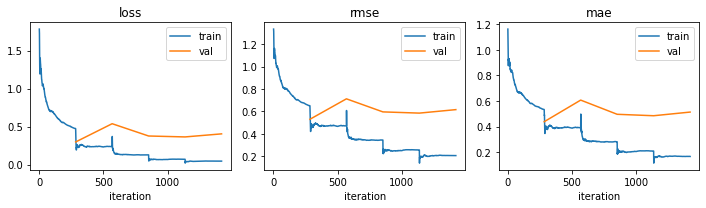

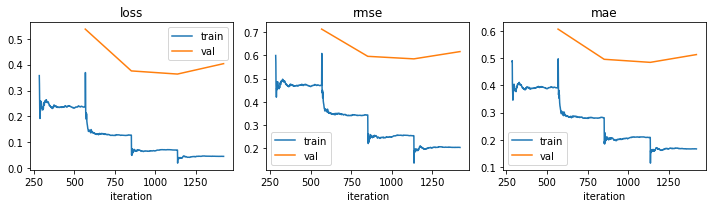

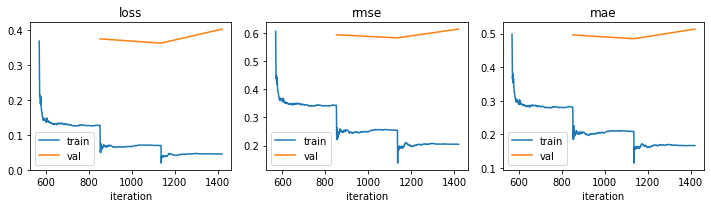

In [16]:
plot_history(learner, 0)
plot_history(learner, 1)
plot_history(learner, 2)

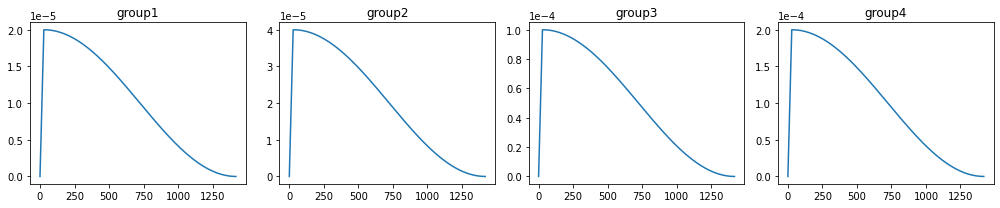

In [18]:
plot_lr(learner)